# **Visualization**

This notebook **reads the Gold layer outputs** and creates visualizations:

- Country-wide yearly temperature anomaly trends (Norway).
- Monthly climate normals (2010–2020) for Norway.
- Monthly anomaly heatmap (year × month).
- Example station-level trends.

All inputs come from:

- `/home/ubuntu/spark-notebooks/project/data/gold/*`

## 1. Setup Spark & paths

In [11]:
from pyspark.sql import SparkSession, functions as F
import matplotlib.pyplot as plt

# Start / reuse Spark
spark = (SparkSession.builder
         .appName("GHCN-Gold-Visualization")
         .getOrCreate())
spark.sparkContext.setLogLevel("WARN")

print("Spark:", spark.version)

# Paths
GOLD_DIR      = "/home/ubuntu/spark-notebooks/project/data/gold"

OUT_STN_MONTHLY = f"{GOLD_DIR}/station_monthly"
OUT_STN_YEARLY  = f"{GOLD_DIR}/station_yearly"
OUT_NORM_9120   = f"{GOLD_DIR}/normals_1991_2020"
OUT_ANOM_MONTH  = f"{GOLD_DIR}/anomalies_monthly"
OUT_ANOM_YEAR   = f"{GOLD_DIR}/anomalies_yearly"
OUT_REG_MONTH   = f"{GOLD_DIR}/region_monthly"
OUT_REG_YEAR    = f"{GOLD_DIR}/region_yearly"

OUT_LR_REGION_FORECAST = f"{GOLD_DIR}/ml_lr_region_forecast"
OUT_RF_PRCPT           = f"{GOLD_DIR}/ml_rf_station_prcp"
OUT_GBT_TANOM          = f"{GOLD_DIR}/ml_gbt_station_tanom"
OUT_KMEANS_CLUSTERS    = f"{GOLD_DIR}/ml_kmeans_clusters"
OUT_LOGR_HEATWAVE      = f"{GOLD_DIR}/ml_logr_heatwave"

# Load Gold tables
station_monthly = spark.read.parquet(OUT_STN_MONTHLY)
station_yearly  = spark.read.parquet(OUT_STN_YEARLY)
normals         = spark.read.parquet(OUT_NORM_9120)
anom_month      = spark.read.parquet(OUT_ANOM_MONTH)
anom_year       = spark.read.parquet(OUT_ANOM_YEAR)
region_month    = spark.read.parquet(OUT_REG_MONTH)
region_year     = spark.read.parquet(OUT_REG_YEAR)

lr_forecast     = spark.read.parquet(OUT_LR_REGION_FORECAST)
rf_pred_viz     = spark.read.parquet(OUT_RF_PRCPT)
gbt_pred_viz    = spark.read.parquet(OUT_GBT_TANOM)
kmeans_viz      = spark.read.parquet(OUT_KMEANS_CLUSTERS)
logr_viz        = spark.read.parquet(OUT_LOGR_HEATWAVE)

print("Loaded Gold tables.")

Spark: 3.5.0
Loaded Gold tables.


## 2. Norway monthly climate normals (2010–2020)

We use the `normals_1991_2020` table and average across all Norwegian stations
to get a **typical annual cycle** for:
- mean temperature per month
- total precipitation per month

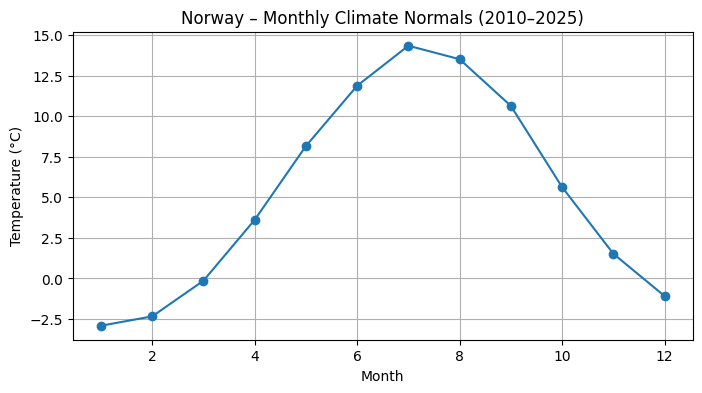

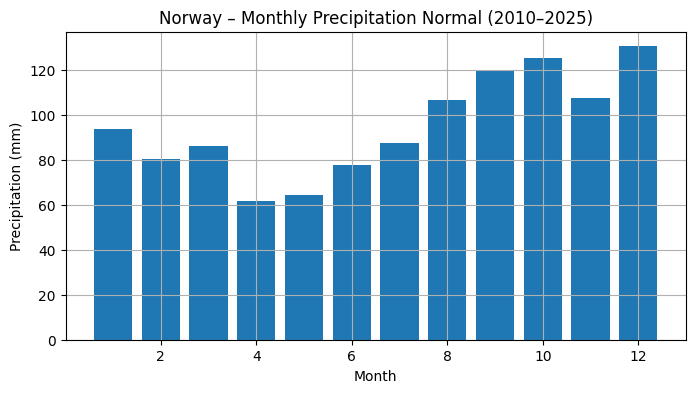

In [18]:
# Keep only Norway
norm_no = normals.filter(F.col("country") == "NO")

# Average over all stations per month
norm_no_month = (norm_no
    .groupBy("month")
    .agg(
        F.avg("normal_tavg_c").alias("normal_tavg_c"),
        F.avg("normal_prcp_total_mm").alias("normal_prcp_total_mm")
    )
    .orderBy("month")
)

norm_no_pd = norm_no_month.toPandas()

fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(norm_no_pd["month"], norm_no_pd["normal_tavg_c"], marker="o")
ax1.set_xlabel("Month")
ax1.set_ylabel("Temperature (°C)")
ax1.set_title("Norway – Monthly Climate Normals (2010–2025)")

ax1.grid(True)

plt.show()

# Optional: separate plot for precipitation
plt.figure(figsize=(8,4))
plt.bar(norm_no_pd["month"], norm_no_pd["normal_prcp_total_mm"])
plt.xlabel("Month")
plt.ylabel("Precipitation (mm)")
plt.title("Norway – Monthly Precipitation Normal (2010–2025)")
plt.grid(True)
plt.show()


## 3. Heatmap of monthly temperature anomalies (Norway)

We use `region_monthly` to create a **year × month heatmap** of
`region_tavg_anom_c` (°C anomaly).


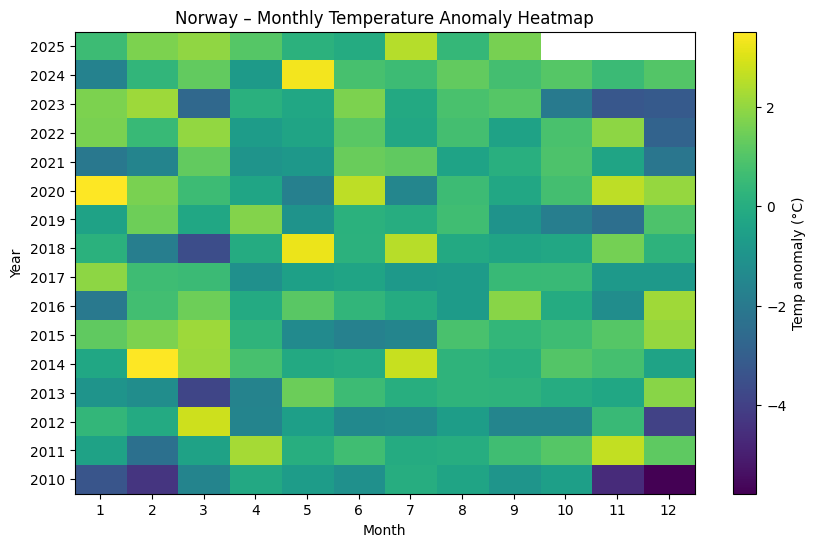

In [19]:
# Filter Norway and select needed columns
no_reg_month = (region_month
    .filter(F.col("country") == "NO")
    .select("year", "month", "region_tavg_anom_c"))

no_reg_month_pd = no_reg_month.toPandas()

# Pivot to year x month table
heat_df = no_reg_month_pd.pivot(index="year", columns="month", values="region_tavg_anom_c")
heat_df = heat_df.sort_index()  # years in order

plt.figure(figsize=(10,6))
plt.imshow(heat_df, aspect="auto", origin="lower")
plt.colorbar(label="Temp anomaly (°C)")
plt.xticks(range(12), range(1,13))
plt.yticks(range(len(heat_df.index)), heat_df.index)
plt.xlabel("Month")
plt.ylabel("Year")
plt.title("Norway – Monthly Temperature Anomaly Heatmap")
plt.show()


## 4. Norway yearly temperature anomaly (country average)

We use `region_yearly` and plot **region_tavg_anom_c** over time for Norway.

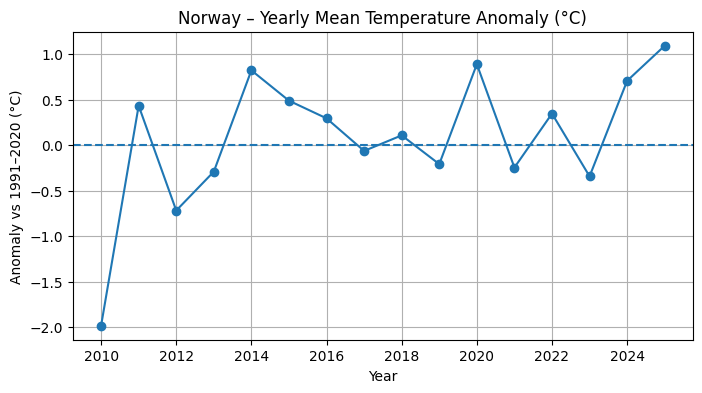

In [20]:
# Filter Norway and order by year
no_year = (region_year
           .filter(F.col("country") == "NO")
           .orderBy("year"))

no_year_pd = no_year.select("year", "region_tavg_anom_c").toPandas()

plt.figure(figsize=(8,4))
plt.plot(no_year_pd["year"], no_year_pd["region_tavg_anom_c"], marker="o")
plt.axhline(0, linestyle="--")
plt.title("Norway – Yearly Mean Temperature Anomaly (°C)")
plt.xlabel("Year")
plt.ylabel("Anomaly vs 1991–2020 (°C)")
plt.grid(True)
plt.show()

## 5. Norway Monthly temperature anomaly (2010 vs 2020)

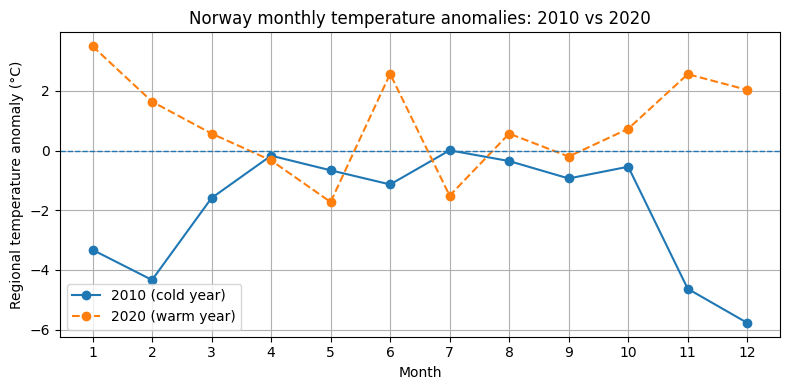

In [21]:
cold_year = 2010
warm_year = 2020

reg_cold = (region_month
    .filter((F.col("country") == "NO") & (F.col("year") == cold_year))
    .orderBy("month")
    .select("month", "region_tavg_anom_c")
    .toPandas()
)

reg_warm = (region_month
    .filter((F.col("country") == "NO") & (F.col("year") == warm_year))
    .orderBy("month")
    .select("month", "region_tavg_anom_c")
    .toPandas()
)

plt.figure(figsize=(8, 4))
plt.plot(reg_cold["month"], reg_cold["region_tavg_anom_c"],
         marker="o", label=f"{cold_year} (cold year)")
plt.plot(reg_warm["month"], reg_warm["region_tavg_anom_c"],
         marker="o", linestyle="--", label=f"{warm_year} (warm year)")
plt.axhline(0.0, linestyle="--", linewidth=1)

plt.xlabel("Month")
plt.ylabel("Regional temperature anomaly (°C)")
plt.title(f"Norway monthly temperature anomalies: {cold_year} vs {warm_year}")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 6. Example station: annual mean temperature for one station

We pick the station **TROMSO** (`id = "NO000001026"`) and plot its yearly mean temperature.


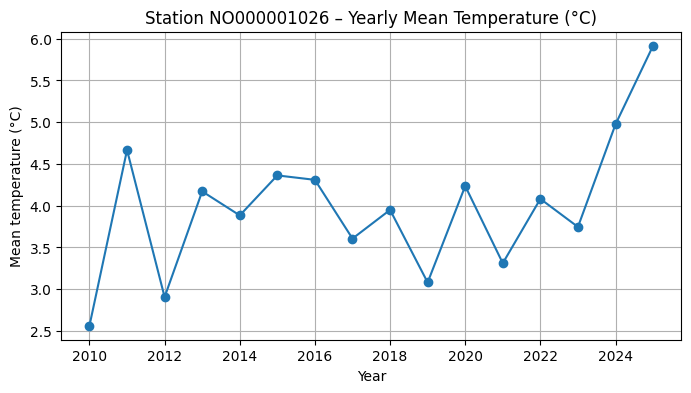

In [22]:
station_id = "NO000001026"   # Tromsø; change for another station

stn_series = (station_yearly
    .filter(F.col("id") == station_id)
    .orderBy("year")
    .select("year", "year_tavg_mean_c"))

stn_pd = stn_series.toPandas()

plt.figure(figsize=(8,4))
plt.plot(stn_pd["year"], stn_pd["year_tavg_mean_c"], marker="o")
plt.title(f"Station {station_id} – Yearly Mean Temperature (°C)")
plt.xlabel("Year")
plt.ylabel("Mean temperature (°C)")
plt.grid(True)
plt.show()

## 7. Example station: monthly climate normals vs year_example for one specific station

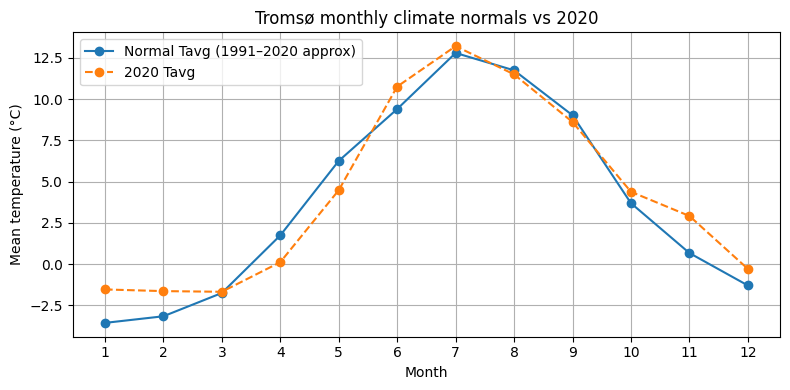

In [23]:
import pandas as pd

stn_id = "NO000001026"   # Tromsø
year_example = 2020      # pick a “warm” or interesting year

norm_stn = (normals
    .filter(F.col("id") == stn_id)
    .orderBy("month")
    .select("month", "normal_tavg_c")
    .toPandas()
)

year_stn = (station_monthly
    .filter((F.col("id") == stn_id) & (F.col("year") == year_example))
    .orderBy("month")
    .select("month", "tavg_mean_c")
    .toPandas()
)

plt.figure(figsize=(8, 4))
plt.plot(norm_stn["month"], norm_stn["normal_tavg_c"],
         marker="o", label="Normal Tavg (1991–2020 approx)")
plt.plot(year_stn["month"], year_stn["tavg_mean_c"],
         marker="o", linestyle="--", label=f"{year_example} Tavg")

plt.xlabel("Month")
plt.ylabel("Mean temperature (°C)")
plt.title(f"Tromsø monthly climate normals vs {year_example}")
plt.xticks(range(1, 13))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 08. Linear Regression — predict temperature anomaly from year

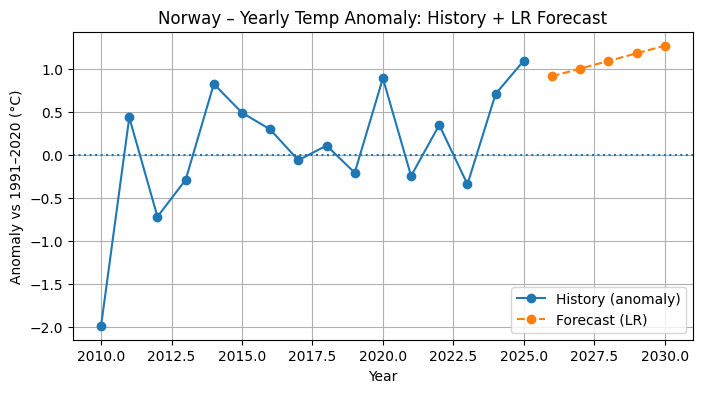

In [6]:
# History from region_yearly (Norway)
no_hist = (region_year
    .filter(F.col("country") == "NO")
    .orderBy("year")
    .select("year", "region_tavg_anom_c"))

no_hist_pd = no_hist.toPandas()

# Forecast from LR model
no_fc = (lr_forecast
    .filter(F.col("country") == "NO")
    .orderBy("year")
    .select("year", "prediction"))

no_fc_pd = no_fc.toPandas()

plt.figure(figsize=(8,4))

# Historical anomalies
plt.plot(no_hist_pd["year"], no_hist_pd["region_tavg_anom_c"],
         marker="o", label="History (anomaly)")

# Forecast anomalies
plt.plot(no_fc_pd["year"], no_fc_pd["prediction"],
         marker="o", linestyle="--", label="Forecast (LR)")

plt.axhline(0, linestyle=":")
plt.title("Norway – Yearly Temp Anomaly: History + LR Forecast")
plt.xlabel("Year")
plt.ylabel("Anomaly vs 1991–2020 (°C)")
plt.legend()
plt.grid(True)
plt.show()


## 09. Random Forest — predict yearly rainfall (station-level)

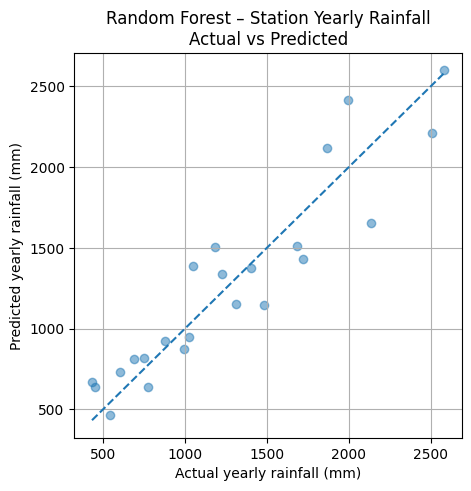

In [7]:
# Take a small sample for plotting
rf_pd = rf_pred_viz.sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(5,5))
plt.scatter(rf_pd["label"], rf_pd["prediction"], alpha=0.5)
plt.plot([rf_pd["label"].min(), rf_pd["label"].max()],
         [rf_pd["label"].min(), rf_pd["label"].max()],
         linestyle="--")
plt.xlabel("Actual yearly rainfall (mm)")
plt.ylabel("Predicted yearly rainfall (mm)")
plt.title("Random Forest – Station Yearly Rainfall\nActual vs Predicted")
plt.grid(True)
plt.show()


## 10. GBT Regressor — predict yearly temperature anomaly (station-level)

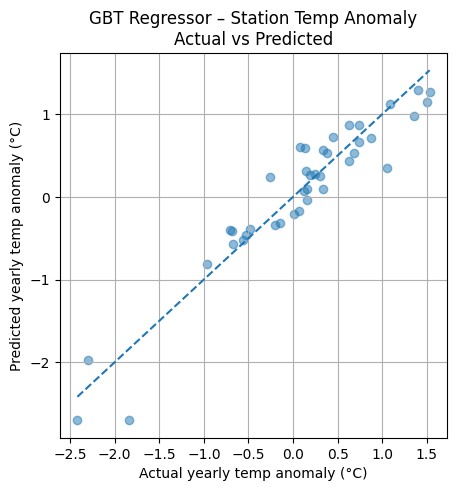

In [8]:
gbt_pd = gbt_pred_viz.sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(5,5))
plt.scatter(gbt_pd["label"], gbt_pd["prediction"], alpha=0.5)
plt.plot([gbt_pd["label"].min(), gbt_pd["label"].max()],
         [gbt_pd["label"].min(), gbt_pd["label"].max()],
         linestyle="--")
plt.xlabel("Actual yearly temp anomaly (°C)")
plt.ylabel("Predicted yearly temp anomaly (°C)")
plt.title("GBT Regressor – Station Temp Anomaly\nActual vs Predicted")
plt.grid(True)
plt.show()


## 11. K-Means — cluster stations into climate zones

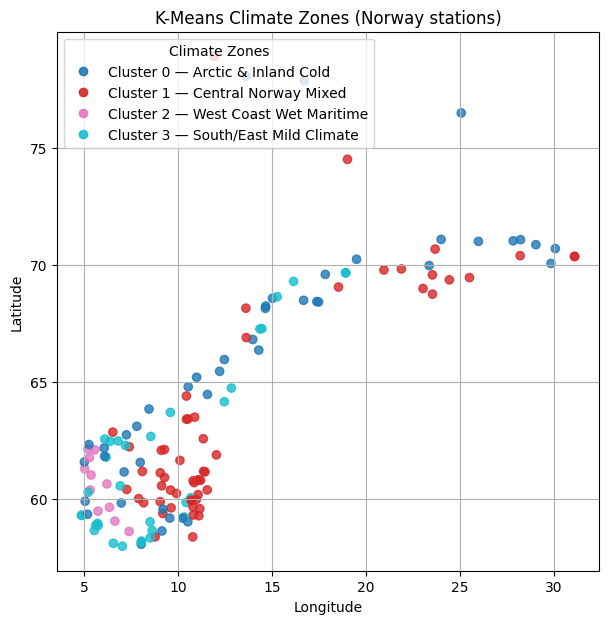

In [9]:
# Cluster label mapping (based on geographic interpretation)
cluster_labels = {
    0: "Cluster 0 — Arctic & Inland Cold",
    1: "Cluster 1 — Central Norway Mixed",
    2: "Cluster 2 — West Coast Wet Maritime",
    3: "Cluster 3 — South/East Mild Climate"
}

# Convert Spark DF to Pandas for plotting
k_pd = kmeans_viz.toPandas()

# Create a color map
colors = plt.cm.tab10  # 10 distinct colors

plt.figure(figsize=(7,7))

# Plot
scatter = plt.scatter(
    k_pd["lon"],
    k_pd["lat"],
    c=k_pd["cluster"],
    cmap=colors,
    alpha=0.8
)

# Build labeled legend
handles, _ = scatter.legend_elements(prop="colors", alpha=0.9)
labels = [cluster_labels[i] for i in sorted(k_pd["cluster"].unique())]

plt.legend(handles, labels, title="Climate Zones", loc="upper left")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means Climate Zones (Norway stations)")
plt.grid(True)
plt.show()


## 12. Logistic Regression — “heatwave year” classification

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  245|
|       1.0|    5|
+----------+-----+



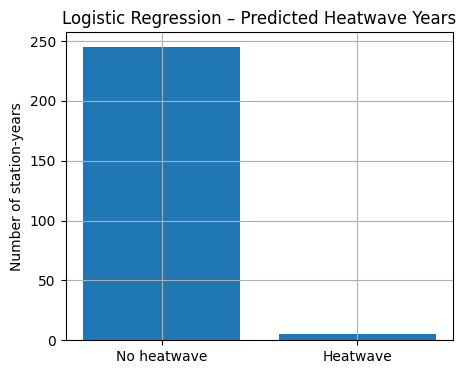

In [10]:
# Count predicted classes
logr_counts = (logr_viz
    .groupBy("prediction")
    .count()
    .orderBy("prediction"))

logr_counts.show()

logr_pd = logr_counts.toPandas()

labels = ["No heatwave", "Heatwave"]
plt.figure(figsize=(5,4))
plt.bar(labels, logr_pd["count"])
plt.title("Logistic Regression – Predicted Heatwave Years")
plt.ylabel("Number of station-years")
plt.grid(True)
plt.show()
